In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

from simtk import unit
from openmmtools.constants import kB
temperature = 300.0 * unit.kelvin
kT = kB * temperature

import random

from pymbar import EXP

In [8]:
outputs = {}
for d in os.listdir('../jnk1/off/'):
    pair = tuple([int(i) for i in d[3:].split('to')])
    outputs[pair] = d
    
jnk1_ligands = [i for i in range(21)]
all_results = {i:{} for i in jnk1_ligands}
oldnew = {0:'old',1:'new'}

In [9]:
for ligand in jnk1_ligands:
    for output in outputs.keys():
        if ligand in output:
            endstate = oldnew[output.index(ligand)]
            solventfile = f'../jnk1/off/{outputs[output]}/{endstate}_solvent.npy'
            if os.path.exists(solventfile):
                solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                all_results[ligand][f'solvent-{outputs[output]}'] = solvent
            complexfile = f'../jnk1/off/{outputs[output]}/{endstate}_complex.npy'
            if os.path.exists(complexfile):
                complex = np.load(complexfile,allow_pickle=True).flatten()[0]
                all_results[ligand][f'complex-{outputs[output]}'] = complex

Correction is 9.35 (1.09) kcal/mol for ligand 0


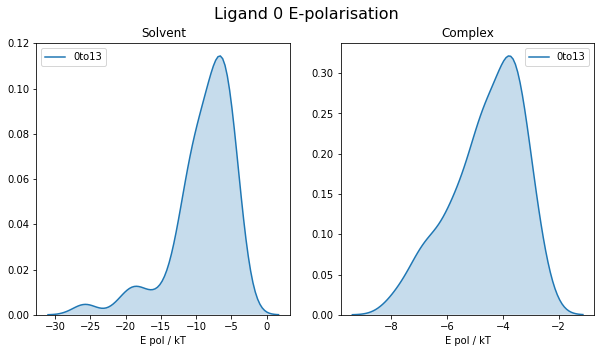

Correction is 25.13 (5.75) kcal/mol for ligand 1


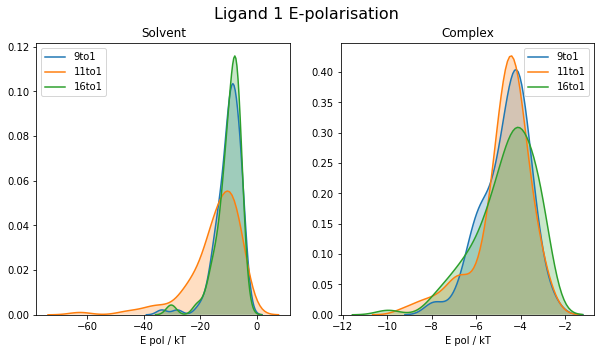

Correction is 7.79 (1.06) kcal/mol for ligand 2


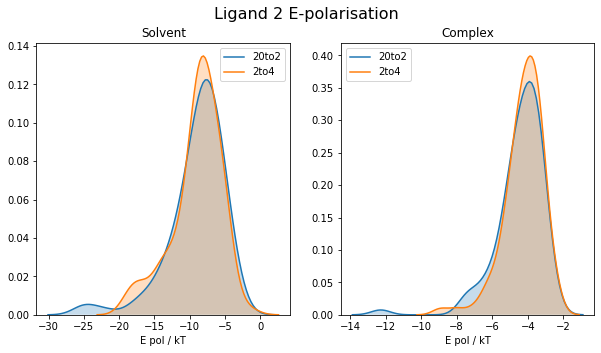

Correction is 6.62 (0.65) kcal/mol for ligand 3


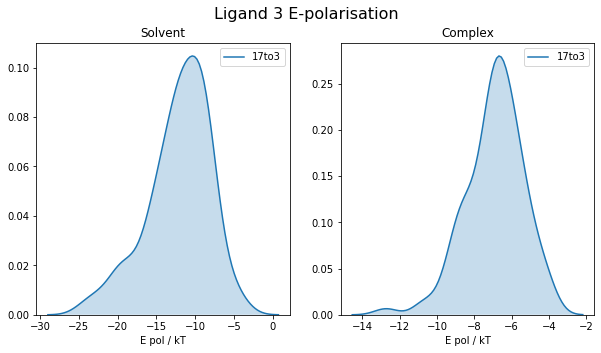

Correction is 10.39 (0.82) kcal/mol for ligand 4


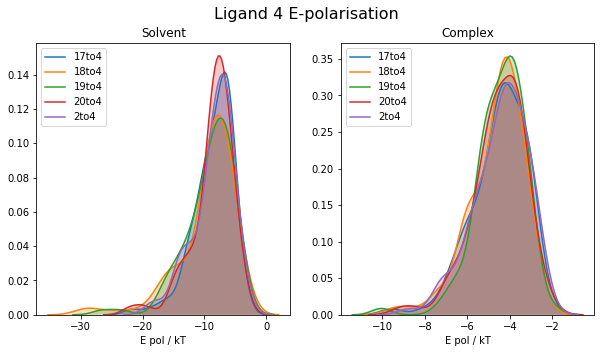

Correction is 10.13 (1.50) kcal/mol for ligand 8


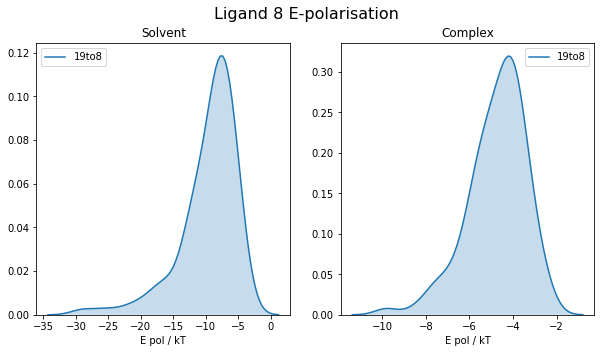

Correction is 6.93 (1.01) kcal/mol for ligand 9


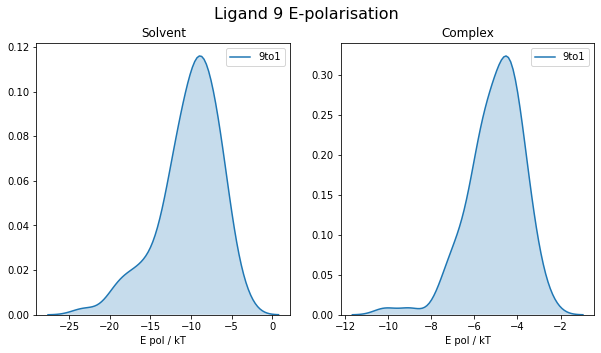

Correction is 15.13 (2.96) kcal/mol for ligand 10


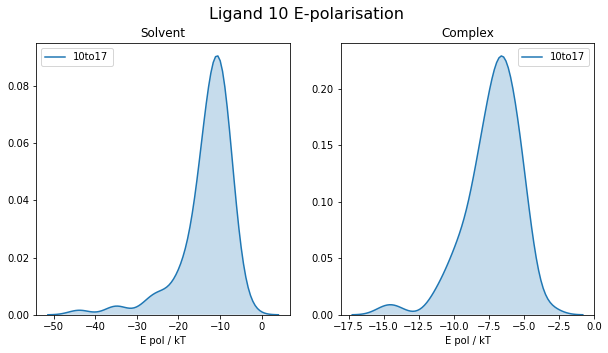

Correction is 33.03 (6.70) kcal/mol for ligand 11


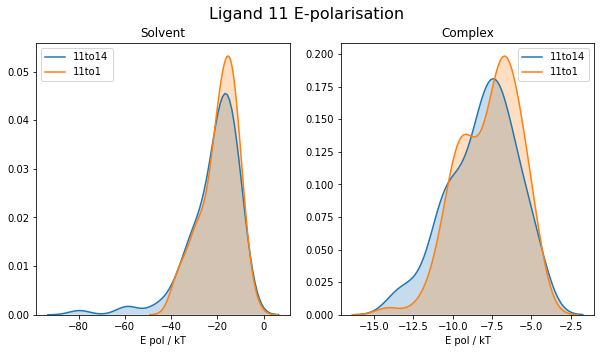

Correction is 9.40 (1.73) kcal/mol for ligand 12


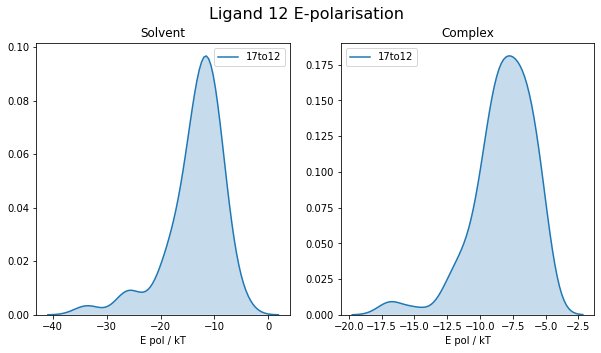

13
Correction is 10.87 (3.19) kcal/mol for ligand 13


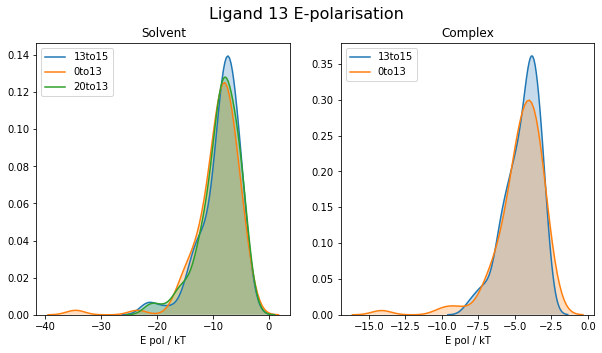

Correction is 20.91 (1.81) kcal/mol for ligand 14


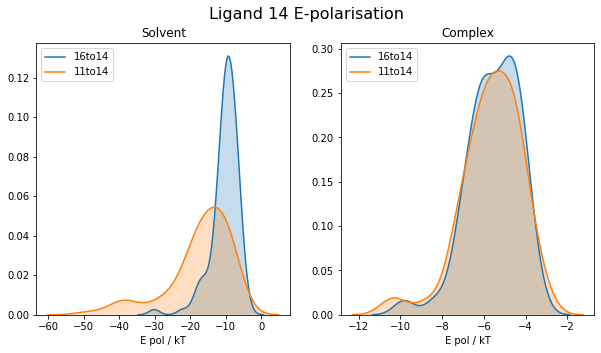

Correction is 6.72 (0.90) kcal/mol for ligand 15


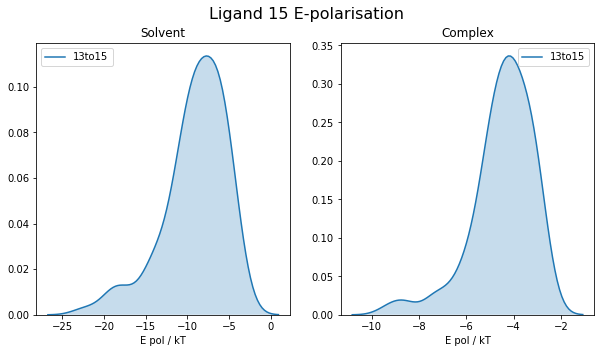

Correction is 10.49 (1.16) kcal/mol for ligand 16


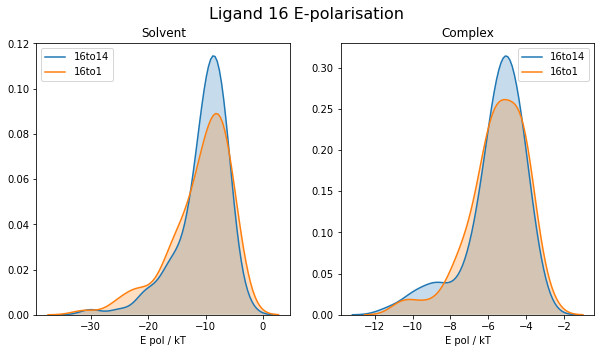

Correction is 11.35 (0.97) kcal/mol for ligand 17


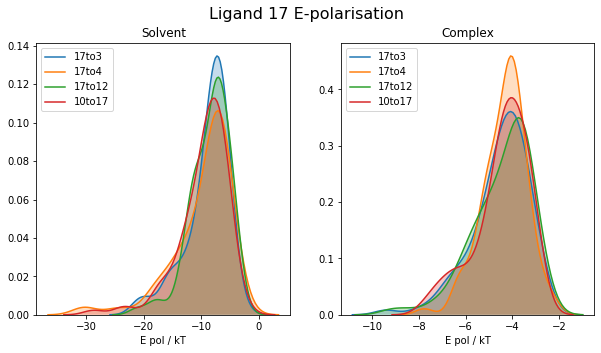

Correction is 6.35 (1.18) kcal/mol for ligand 18


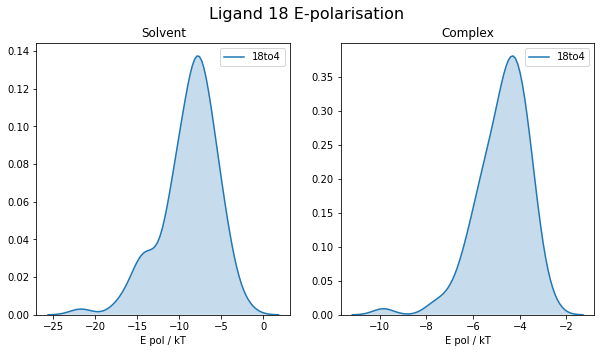

Correction is 11.34 (1.07) kcal/mol for ligand 19


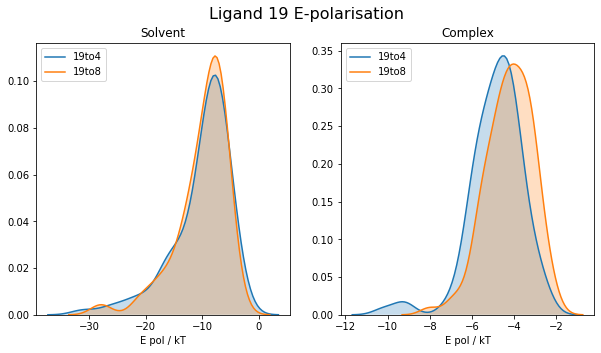

20
Correction is 11.48 (1.67) kcal/mol for ligand 20


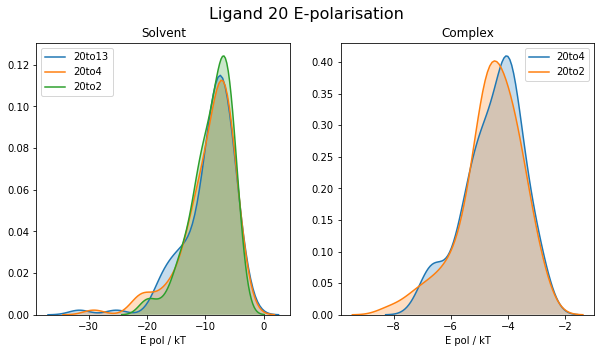

In [12]:
hartree_to_kT = ((1*unit.hartree).in_units_of(unit.joules)*unit.AVOGADRO_CONSTANT_NA / kT)


for ligand in all_results.keys():
    if len(all_results[ligand]) > 0:
        all_solvent_for_lig = []
        all_complex_for_lig = []
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
        for thing in all_results[ligand]:
            if 'solvent' in thing:
                Epol = all_results[ligand][thing]['Epol']*hartree_to_kT
                if len(Epol) != 100:
                    print(ligand)
                    continue
                sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[0])
                all_solvent_for_lig.extend(Epol)
            elif 'complex' in thing:
                Epol = all_results[ligand][thing]['Epol']*hartree_to_kT
                if len(Epol) != 100:
                    print(ligand)
                    continue
                sns.kdeplot(Epol,label=thing.split('-lig')[1],shade=True,ax=axes[1])
                all_complex_for_lig.extend(Epol)

        if len(all_solvent_for_lig) > 0 and len(all_complex_for_lig) > 0:
            bootstraps = []
            for _ in range(100):
                comp = random.choices(all_complex_for_lig, k=len(all_complex_for_lig))
                sol = random.choices(all_solvent_for_lig, k=len(all_solvent_for_lig))
                corr_comp, err_comp = EXP(np.asarray(comp))
                corr_sol, err_sol = EXP(np.asarray(sol))
#                 err = (err_comp**2 + err_sol**2)**0.5
                bootstraps.append((corr_comp - corr_sol)*0.593)
            print(f'Correction is {np.mean(bootstraps):.2f} ({np.std(bootstraps):.2f}) kcal/mol for ligand {ligand}')
        axes[0].set_title('Solvent')
        axes[1].set_title('Complex')
        axes[0].set_xlabel('E pol / kT')
        axes[1].set_xlabel('E pol / kT')
        fig.suptitle(f"Ligand {ligand} E-polarisation", fontsize=16)

        plt.legend()
        plt.show()

In [13]:
import mdtraj as md

### Looking at closest distance between any ligand atom and Na+

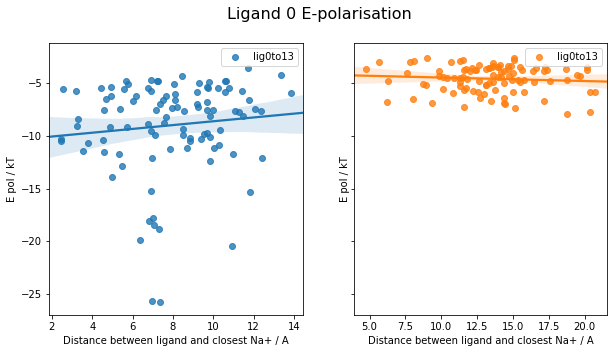

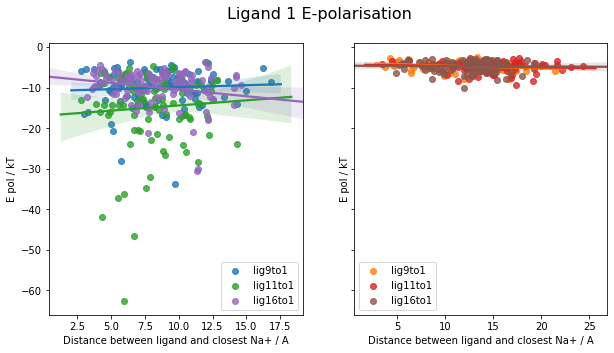

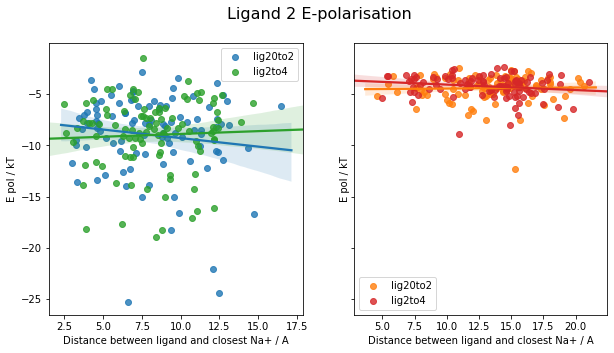

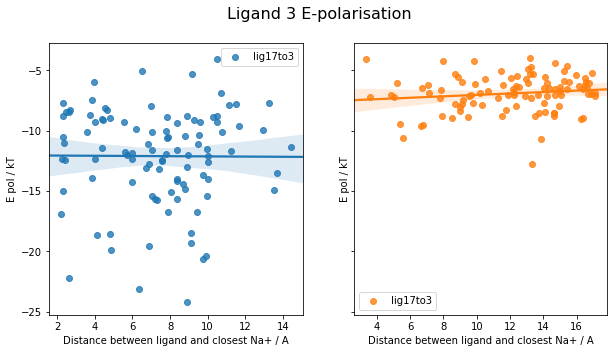

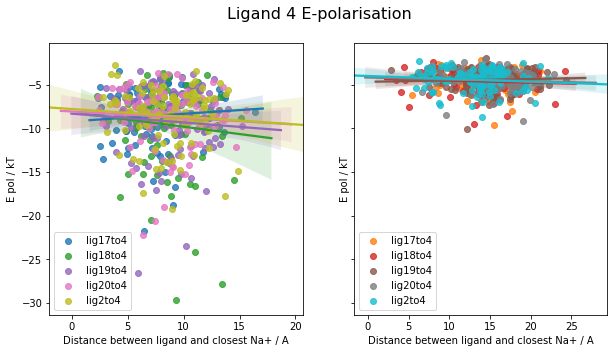

No handles with labels found to put in legend.
No handles with labels found to put in legend.


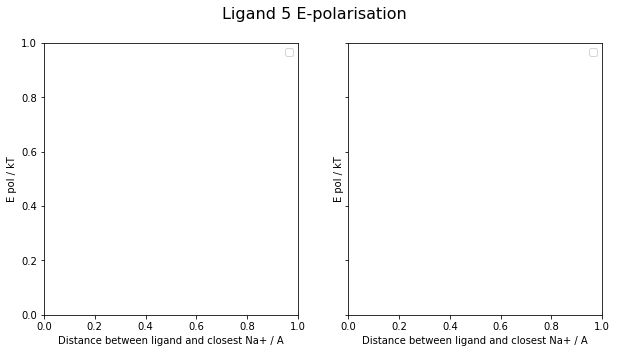

No handles with labels found to put in legend.
No handles with labels found to put in legend.


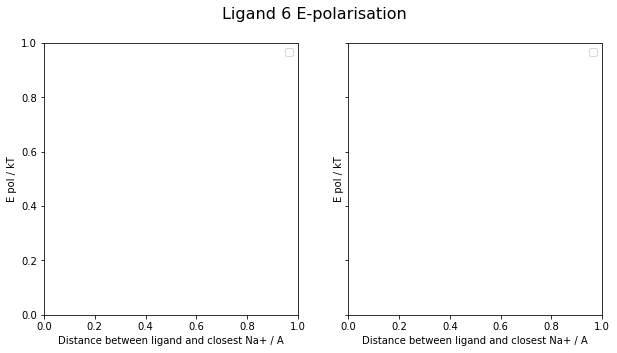

No handles with labels found to put in legend.
No handles with labels found to put in legend.


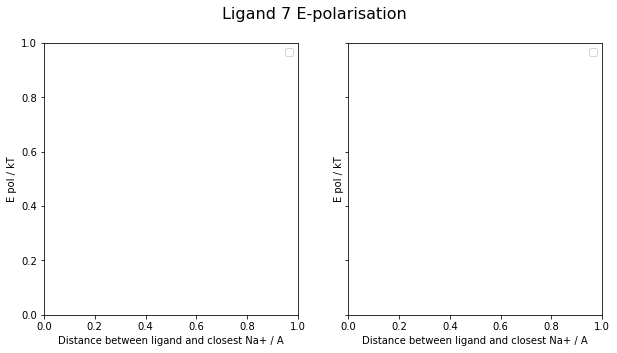

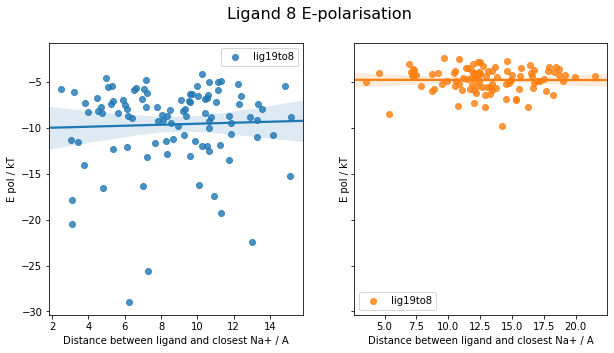

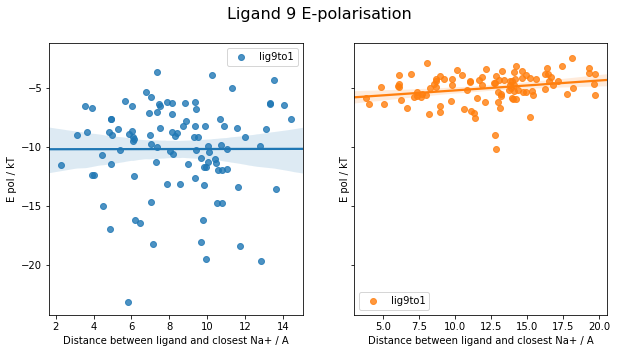

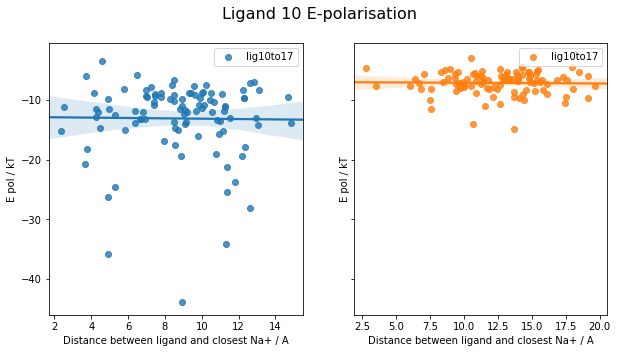

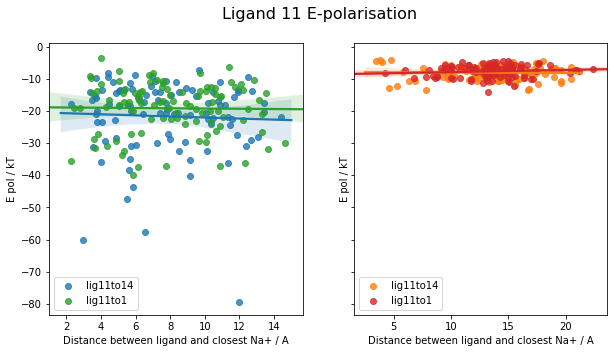

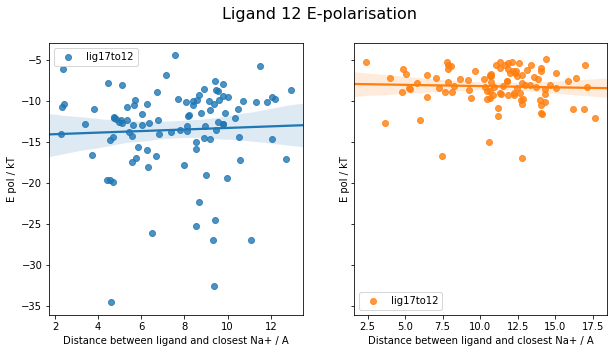

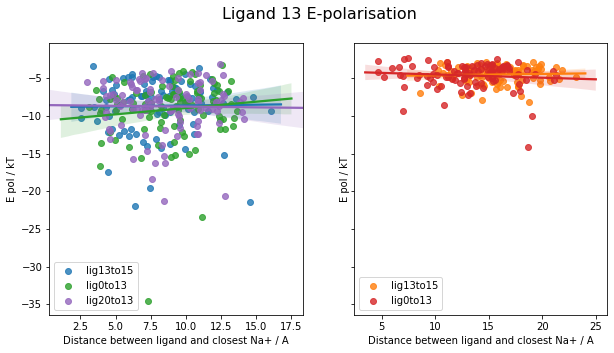

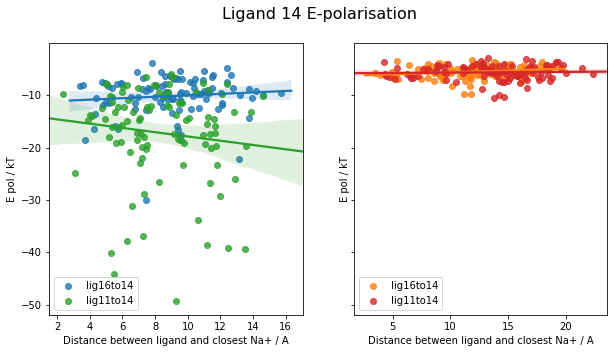

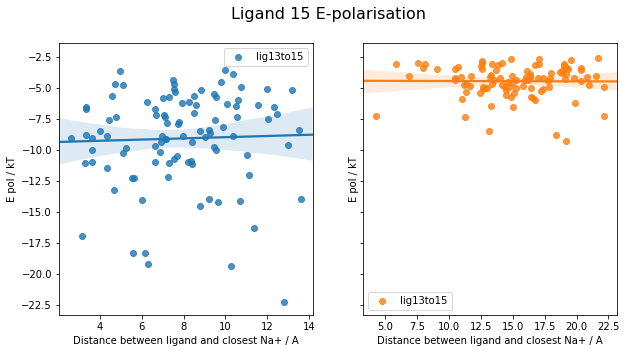

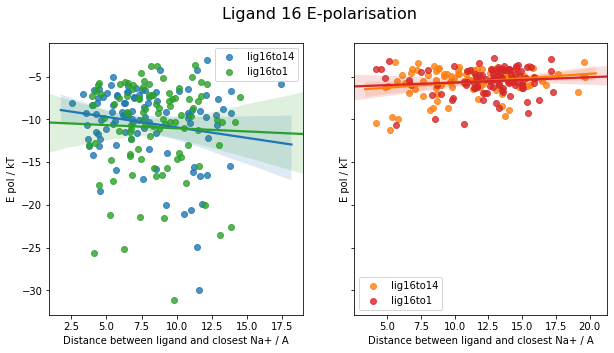

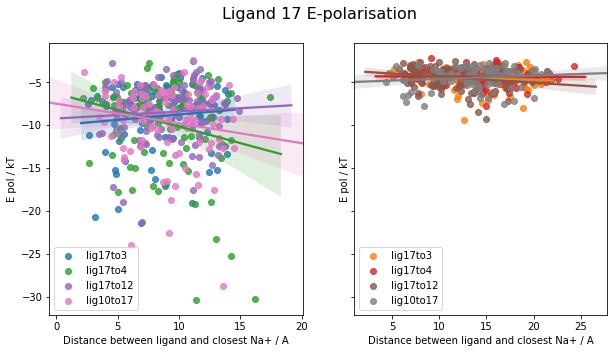

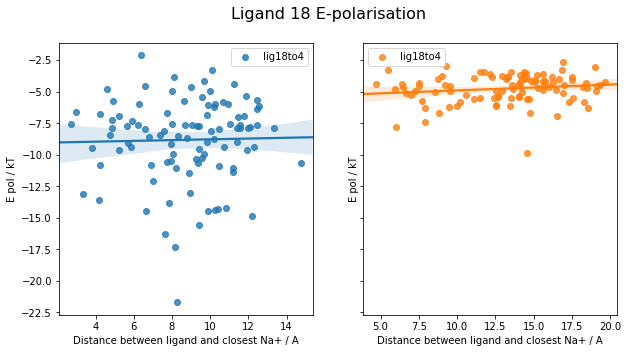

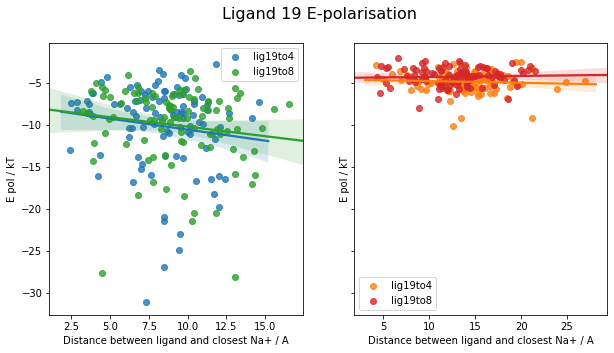

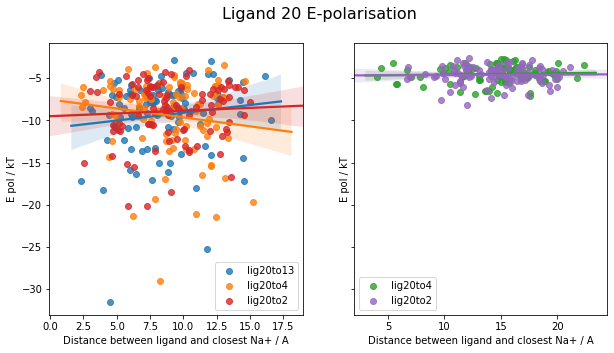

In [125]:
ax = {'solvent':0, 'complex':1}


for ligand in all_results.keys():
    fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5),sharey=True)
    for thing in all_results[ligand]:
        phase, directory = thing.split('-')
        
        if str(ligand) == thing.split('to')[1]:
            state = 'new'
        else:
            state = 'old'
        topology = md.load(f'../jnk1/off/{directory}/{state}_{phase}.pdb').topology
        t = md.load(f'../jnk1/off/{directory}/{state}_positions_{phase}.dcd', top=topology)

        ligand_ids = []
        ions_ids = []
        for r in topology.residues:
            if r.name == 'MOL': 
                for a in r.atoms:
                    ligand_ids.append(a.index)
            if r.name == 'NA': 
                  for a in r.atoms:
                    ions_ids.append(a.index)

        comparisons = [[i,j] for i in ligand_ids for j in ions_ids]
        ion_dist = md.compute_distances(t,comparisons)

        
        closest_ion = np.min(ion_dist,axis=1)
        if len(closest_ion) == 101 and len(all_results[ligand][thing]['Epol']) == 100:
            sns.regplot(10*closest_ion[1:],all_results[ligand][thing]['Epol']*hartree_to_kT,ax=axes[ax[phase]],label=directory)
        

    axes[0].set_xlabel('Shortest di / A')
    axes[0].set_ylabel('E pol / kT')
    axes[0].legend()
    axes[1].set_xlabel('Distance between ligand and closest Na+ / A')
    axes[1].set_ylabel('E pol / kT')
    axes[1].legend()
    fig.suptitle(f"Ligand {ligand} E-polarisation", fontsize=16)
    plt.show()